## 載入套件

In [1]:
import os
import re
import pickle
import numpy as np
import pandas as pd
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_percentage_error

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('font', family='Microsoft JhengHei')
plt.rcParams['axes.unicode_minus'] = False

%matplotlib inline

## 單價相關係數

In [2]:
# 讀取資料
'''
此份檔案為2.Preproc_modeling 中前處理完成後之資料
(train_x, train_y, valid_x, valid_y)

為準確地反映相關係數的狀況，並未對特徵進行quantisation
'''

with open('final_version_preproc_data_noq.pkl', 'rb') as f:
    train_x, train_y, valid_x, valid_y = pickle.load(f)

In [3]:
total_df = pd.concat([train_x, valid_x])
total_df['單價'] = pd.concat([train_y, valid_y])
total_df.shape

(11749, 517)

In [4]:
# 逐次取每個特徵，移除遺漏值(固定為-1)後與單價計算相關係數

corr_ls = []
c_ls = []
for c in total_df.columns:
    if c=='單價':
        continue
    corr_ls.append(total_df[total_df[c]>0][['單價', c]].corr()['單價'].iloc[1])
    c_ls.append(c)


In [5]:
# 與單價相關係數最高的30個特徵
pd.DataFrame({'columns':c_ls, 'corr':corr_ls}).dropna().sort_values('corr').tail(30)

columns      corr
44       price_sd_屋齡_型態_移轉層次  0.789123
23               price_sd_移轉  0.789154
31            price_sd_屋齡_型態  0.798052
103              price_sd_型態  0.806938
113              price_sd_屋齡  0.810949
107           total_price_型態  0.811513
143             price_路名_rev  0.823073
150             price_型態_rev  0.842823
286  price_屋齡_neighbor_mean1  0.858809
284  price_精準_neighbor_mean1  0.871824
22                  price_移轉  0.889820
93                  price_路名  0.903164
131          price_路名_型態2023  0.910803
119          price_路名_型態2020  0.916630
112                 price_屋齡  0.917241
30               price_屋齡_型態  0.921228
43          price_屋齡_型態_移轉層次  0.921603
82               price_路名_型態  0.929192
123            price_同建物2020  0.929257
127             price_精準2020  0.936836
135            price_同建物2023  0.941655
513            單價rs_mean1000  0.955716
139             price_精準2023  0.956578
515         單價r_mean_age1000  0.962710
56            price_屋齡_型態_路名  0.963289
511             單價rs_mean200  0.964924
69                 price_同建物  0.970935
514        單價rs_mean_age1000  0.972933
12                  price_精準  0.973775
512         單價rs_mean_age200  0.974237

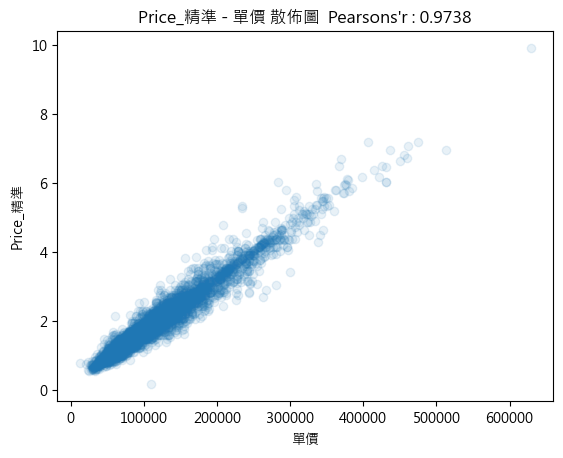

In [6]:
# 取 Price_精準 (實價登錄衍生特徵中相關係數最高者) 繪製散佈圖

plt.scatter(total_df[total_df['price_精準']>0]['price_精準'],
            total_df[total_df['price_精準']>0]['單價'], alpha = 0.1)
plt.title(f'Price_精準 - 單價 散佈圖  Pearsons\'r : 0.9738')
plt.xlabel('單價')
plt.ylabel('Price_精準')
plt.show()

In [7]:
# 計算不同篩選條件下之實價登錄衍生特徵(以price做代表)之未配對比例

out_list = []
c_list = []
for c in train_x.filter(regex='price'):
    out_list.append(np.mean(total_df[c]<0))
    c_list.append(c)

pd.DataFrame({'columns':c_list, 'non_mapping_percent':out_list})

columns  non_mapping_percent
0                   price_精準             0.551281
1                price_sd_精準             0.828411
2              price_skew_精準             0.865606
3             total_price_精準             0.551281
4           parking_price_精準             0.551281
..                       ...                  ...
72           ref_price_路名_屋齡             0.454422
73        ref_price_路名_型態_型態             0.518172
74           ref_price_型態_移轉             0.381309
75  ref_price_路名_型態_路名_型態_屋齡             0.381735
76          rev_路名_price_pro             0.637501

[77 rows x 2 columns]

## 模型表現差異測試
以不同特徵組合測試模型表現

In [8]:
# 讀取資料
'''
此份檔案為2.Preproc_modeling 中前處理完成後之資料
(train_x, train_y, valid_x, valid_y)

包含 feature quantisation
'''


with open('final_version_preproc_data.pkl', 'rb') as f:
    train_x, train_y, valid_x, valid_y = pickle.load(f)

In [9]:
print(train_x.shape, valid_x.shape)

(9399, 516) (2350, 516)


In [10]:
def featureset_scores(use_cols):
    
    seeds_list = [630, 810, 521, 806, 107]
    n_repeat = len(seeds_list)
    
    train_mape_list = []
    valid_mape_list = []
    
    for i in range(n_repeat):
        model = LGBMRegressor(n_estimators=10000, learning_rate=5e-2, reg_alpha = 1e-2, reg_lambda = 5e-1, max_depth=12,
                  importance_type="gain", objective='mse', min_child_samples=3, random_state = seeds_list[i],
                  subsample = 0.5, colsample_bytree=0.5, boosting_type = 'dart')
        
        model.fit(train_x.iloc[:,use_cols], train_y)
        
        train_pred = model.predict(train_x.iloc[:,use_cols])
        valid_pred = model.predict(valid_x.iloc[:,use_cols])
        
        train_mape_list.append(mean_absolute_percentage_error(y_true = train_y, y_pred = train_pred))
        valid_mape_list.append(mean_absolute_percentage_error(y_true = valid_y, y_pred = valid_pred))
    
    return train_mape_list, valid_mape_list

### 不同來源之特徵差異比較

In [11]:
# 原始特徵
origin_feature = list(range(0, 12)) + list(range(342, 511))

# 單純衍生特徵
origin_derive = list(range(156, 165))

# 鄰近設施相關特徵
external_feature = list(range(165, 223))

# 周邊特徵(x)
nearest_feature_x = list(range(223, 284)) + list(range(287, 317))

# 周邊特徵(y)
nearest_feature_y = list(range(511, train_x.shape[1]))


# 實價登錄相關特徵
real_price2122_feature = list(range(12,118))+list(range(142,156))

# 實價登錄相關特徵 - 2020
real_price20_feature = list(range(118, 130))

# 實價登錄相關特徵 - 2023
real_price23_feature = list(range(130, 142)) + list(range(326, 327))

# 實價登錄衍生特徵
real_price_derive_feature = list(range(317, 326)) + list(range(327, 342)) + list(range(284, 287))

In [223]:
testing_feature_sets = {
    'FULL_SET': list(range(train_x.shape[1])),
    'ORIGIN_WITHOUTY':origin_feature+origin_derive+nearest_feature_x,
    'ORIGIN':origin_feature+origin_derive+nearest_feature_x+nearest_feature_y,
    'ORIGIN_EXTERNAL': origin_feature+origin_derive+external_feature+nearest_feature_x+nearest_feature_y,
    'ORIGIN_EXT_REAL20':origin_feature+origin_derive+external_feature+nearest_feature_x+nearest_feature_y+real_price20_feature,
    'ORIGIN_EXT_REAL22':origin_feature+origin_derive+external_feature+nearest_feature_x+nearest_feature_y+real_price20_feature+real_price2122_feature+real_price_derive_feature,
}

In [224]:
# 計算不同特徵組合下的mape平均與標準差

for name, use_cols in testing_feature_sets.items():
    
    train_result, valid_result = featureset_scores(use_cols)
    
    print(f'{name} {np.mean(valid_result):.6f} {np.std(valid_result):.6f}')

FULL_SET 0.062660 0.000092
ORIGIN_WITHOUTY 0.077053 0.000163
ORIGIN 0.077531 0.000120
ORIGIN_EXTERNAL 0.076368 0.000106
ORIGIN_EXT_REAL20 0.074355 0.000167
ORIGIN_EXT_REAL22 0.062665 0.000106


In [225]:
# 不同特徵組合之特徵數量

for name, use_cols in testing_feature_sets.items():
    print(name, len(use_cols))

FULL_SET 516
ORIGIN_WITHOUTY 281
ORIGIN 286
ORIGIN_EXTERNAL 344
ORIGIN_EXT_REAL20 356
ORIGIN_EXT_REAL22 503


## 針對實價登錄資料(2021-2022)產生之衍生特徵效果比較

In [249]:
regex_filters = [
    '[a-z]_精準$','[a-z]_移轉$', '[a-z]_屋齡_型態$', '[a-z]_屋齡_型態_移轉層次$', 
    '[a-z]_屋齡_型態_路名$', '[a-z]_同建物$', '[a-z]_路名_型態$', '[a-z]_路名$', '[a-z]_型態$', '[a-z]_屋齡', '[a-z]_路名_rev',
    '[a-z]_型態_rev'
]

In [254]:
# 計算加入不同實價登錄篩選條件所產生之衍生特徵所得到的mape平均與標準差

for name in regex_filters:
    
    ext_cols = [i for i, s in enumerate(train_x.columns) if re.search(name, s)]
    use_cols = origin_feature+origin_derive+external_feature+nearest_feature_x+nearest_feature_y+real_price20_feature + ext_cols
    
    train_result, valid_result = featureset_scores(use_cols)
    
    print(f'{name} {np.mean(valid_result):.6f} {np.std(valid_result):.6f}')

[a-z]_精準$ 0.069082 0.000124
[a-z]_移轉$ 0.074619 0.000259
[a-z]_屋齡_型態$ 0.073495 0.000190
[a-z]_屋齡_型態_移轉層次$ 0.073560 0.000077
[a-z]_屋齡_型態_路名$ 0.069852 0.000047
[a-z]_同建物$ 0.067761 0.000076
[a-z]_路名_型態$ 0.072047 0.000181
[a-z]_路名$ 0.071598 0.000230
[a-z]_型態$ 0.074517 0.000278
[a-z]_屋齡 0.069084 0.000075
[a-z]_路名_rev 0.074372 0.000133
[a-z]_型態_rev 0.074510 0.000110


## 實價登錄資料(2021-2022)數量比例比較

此部分之比較方法為直接執行 1.Extra_feature.ipynb並在實價登錄2021-2022年資料前處理完成後隨機取樣(2020, 2021-2022_rev, 2023 等其餘實價登錄特徵則未放入)，並重新執行2.Preproc_modeling.ipynb，程式碼較為冗長，因此在此僅將模型訓練與驗證階段的結果節錄。

### 實價登錄2021-2022資料 10% 

In [33]:
%%time

m_ls = []
test_pred_ls = []
for i in range(6):
    
    if i%3==0:
        model = LGBMRegressor(n_estimators=10000, learning_rate=5e-2, reg_alpha = 1e-2, reg_lambda = 5e-1, max_depth=12,
                      importance_type="gain", objective='mse', verbose = -1, min_child_samples=3, random_state = 630+i,
                      subsample = 0.5, colsample_bytree=0.5, boosting_type = 'dart')
    elif i%3==1:
        model = LGBMRegressor(boosting_type='gbdt', n_estimators=10000, learning_rate=1e-2,num_leaves = 31, max_depth = -1,
                              random_state = 630+i, min_child_samples=5, 
                          subsample=0.5, colsample_bytree=0.5, reg_alpha=3e-1, reg_lambda=3e-1, subsample_freq=4)
    else:
        model = LGBMRegressor(n_estimators=10000, learning_rate=1e-1, reg_alpha = 1e-1, reg_lambda = 5e-1, max_depth=12, random_state = 630+i,
                      importance_type="gain", objective='mse', drop_rate = 0.1, skip_drop = 0.8, max_drop = 50, xgboost_dart_mode = False,
                      subsample = 0.5, colsample_bytree=0.5, boosting_type = 'dart')
    
    model.fit(train_x, train_y)

    train_pred = model.predict(train_x)
    print('train error : ', mean_absolute_percentage_error(y_true = train_y, y_pred = train_pred))

    if test_mode:
        test_pred = model.predict(test_x)
        m_ls.append(model)
        test_pred_ls.append(test_pred)    
    else:
        valid_pred = model.predict(valid_x)
        print('valid error : ', mean_absolute_percentage_error(y_true = valid_y, y_pred = valid_pred))
        test_pred_ls.append(valid_pred)

if not test_mode:
    print('valid error (averaging) : ', mean_absolute_percentage_error(y_true = valid_y, y_pred = np.mean(test_pred_ls, axis = 0)))


train error :  0.01005000032751183
valid error :  0.07353571533532727
train error :  0.01255738311037852
valid error :  0.07531112349859596
train error :  0.0032641755459023873
valid error :  0.07340444231598081
train error :  0.00991223324046312
valid error :  0.0739041977932835
train error :  0.012541224650828478
valid error :  0.07556963450347737
train error :  0.0036510308444491213
valid error :  0.07332674924427075
valid error (averaging) :  0.07330389640734472
CPU times: total: 58min 24s
Wall time: 3min 40s


### 實價登錄2021-2022資料 50% 

In [20]:
%%time

m_ls = []
test_pred_ls = []
for i in range(6):
    
    if i%3==0:
        model = LGBMRegressor(n_estimators=10000, learning_rate=5e-2, reg_alpha = 1e-2, reg_lambda = 5e-1, max_depth=12,
                      importance_type="gain", objective='mse', verbose = -1, min_child_samples=3, random_state = 630+i,
                      subsample = 0.5, colsample_bytree=0.5, boosting_type = 'dart')
    elif i%3==1:
        model = LGBMRegressor(boosting_type='gbdt', n_estimators=10000, learning_rate=1e-2,num_leaves = 31, max_depth = -1,
                              random_state = 630+i, min_child_samples=5, 
                          subsample=0.5, colsample_bytree=0.5, reg_alpha=3e-1, reg_lambda=3e-1, subsample_freq=4)
    else:
        model = LGBMRegressor(n_estimators=10000, learning_rate=1e-1, reg_alpha = 1e-1, reg_lambda = 5e-1, max_depth=12, random_state = 630+i,
                      importance_type="gain", objective='mse', drop_rate = 0.1, skip_drop = 0.8, max_drop = 50, xgboost_dart_mode = False,
                      subsample = 0.5, colsample_bytree=0.5, boosting_type = 'dart')
    
    model.fit(train_x, train_y)

    train_pred = model.predict(train_x)
    print('train error : ', mean_absolute_percentage_error(y_true = train_y, y_pred = train_pred))

    if test_mode:
        test_pred = model.predict(test_x)
        m_ls.append(model)
        test_pred_ls.append(test_pred)    
    else:
        valid_pred = model.predict(valid_x)
        print('valid error : ', mean_absolute_percentage_error(y_true = valid_y, y_pred = valid_pred))
        test_pred_ls.append(valid_pred)

if not test_mode:
    print('valid error (averaging) : ', mean_absolute_percentage_error(y_true = valid_y, y_pred = np.mean(test_pred_ls, axis = 0)))


train error :  0.00919947961051544
valid error :  0.06720449092051695
train error :  0.011367041003935204
valid error :  0.06840980696470825
train error :  0.0030759759081931152
valid error :  0.06742849163331761
train error :  0.009051516186069176
valid error :  0.06750577814963944
train error :  0.011418042997002857
valid error :  0.06843307767885451
train error :  0.0034219129288011064
valid error :  0.06769947224920826
valid error (averaging) :  0.0669229921407007
CPU times: total: 58min 12s
Wall time: 3min 39s


### 實價登錄2021-2022資料 100% 

In [45]:
%%time

m_ls = []
test_pred_ls = []
for i in range(6):
    
    if i%3==0:
        model = LGBMRegressor(n_estimators=10000, learning_rate=5e-2, reg_alpha = 1e-2, reg_lambda = 5e-1, max_depth=12,
                      importance_type="gain", objective='mse', verbose = -1, min_child_samples=3, random_state = 630+i,
                      subsample = 0.5, colsample_bytree=0.5, boosting_type = 'dart')
    elif i%3==1:
        model = LGBMRegressor(boosting_type='gbdt', n_estimators=10000, learning_rate=1e-2,num_leaves = 31, max_depth = -1,
                              random_state = 630+i, min_child_samples=5, 
                          subsample=0.5, colsample_bytree=0.5, reg_alpha=3e-1, reg_lambda=3e-1, subsample_freq=4)
    else:
        model = LGBMRegressor(n_estimators=10000, learning_rate=1e-1, reg_alpha = 1e-1, reg_lambda = 5e-1, max_depth=12, random_state = 630+i,
                      importance_type="gain", objective='mse', drop_rate = 0.1, skip_drop = 0.8, max_drop = 50, xgboost_dart_mode = False,
                      subsample = 0.5, colsample_bytree=0.5, boosting_type = 'dart')
    
    model.fit(train_x, train_y)

    train_pred = model.predict(train_x)
    print('train error : ', mean_absolute_percentage_error(y_true = train_y, y_pred = train_pred))

    if test_mode:
        test_pred = model.predict(test_x)
        m_ls.append(model)
        test_pred_ls.append(test_pred)    
    else:
        valid_pred = model.predict(valid_x)
        print('valid error : ', mean_absolute_percentage_error(y_true = valid_y, y_pred = valid_pred))
        test_pred_ls.append(valid_pred)

if not test_mode:
    print('valid error (averaging) : ', mean_absolute_percentage_error(y_true = valid_y, y_pred = np.mean(test_pred_ls, axis = 0)))


train error :  0.008692787060194144
valid error :  0.06313523526415124
train error :  0.010705930195532789
valid error :  0.0642847444333944
train error :  0.002961669604594316
valid error :  0.06303774668659536
train error :  0.008509865409360275
valid error :  0.06304907353510633
train error :  0.010739290713336921
valid error :  0.06394147092587354
train error :  0.00327035359865446
valid error :  0.06294486458406637
valid error (averaging) :  0.06253984926333957
CPU times: total: 58min 54s
Wall time: 3min 46s
